In [1]:
import mhcflurry, seaborn, numpy, pandas, pickle, sklearn, collections, scipy, time
import mhcflurry.dataset
import fancyimpute, locale
from matplotlib import pyplot


import sklearn.metrics
import sklearn.cross_validation
%matplotlib inline


def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')

Using Theano backend.
/Users/tim/venvs/analysis-venv-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Couldn't import dot_parser, loading of dot files will not be possible.


/Users/tim/venvs/analysis-venv-2.7/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
impute_comparison = pandas.read_csv("../data/impute_comparison.csv")
impute_comparison

,activation,allele,dropout_probability,embedding_output_dim,fit_time,fraction_negative,impute,layer_sizes,model_params,n_training_epochs,...,test_auc,test_f1,test_size,test_tau,train_auc,train_f1,train_size,train_tau,layer0_size,model_string
0,tanh,HLA-A0203,0.5,32,1.726369,0.2,False,[64],"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou...",250,...,0.787809,0.483003,5315,0.372769,0.998302,0.947368,50,0.770267,64,"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou..."
1,tanh,HLA-A0203,0.5,32,3.950002,0.2,True,[64],"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou...",250,...,0.815350,0.513711,5315,0.416518,0.998302,0.947368,50,0.824931,64,"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou..."
2,tanh,HLA-A0203,0.5,32,3.298754,0.2,False,[64],"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou...",250,...,0.782669,0.536396,5375,0.384346,1.000000,0.918919,50,0.804755,64,"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou..."
3,tanh,HLA-A0203,0.5,32,4.956206,0.2,True,[64],"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou...",250,...,0.790377,0.546405,5375,0.394875,1.000000,0.918919,50,0.831692,64,"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou..."
4,tanh,HLA-A0203,0.5,32,4.355083,0.2,True,[64],"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou...",250,...,0.813876,0.515342,5369,0.436850,0.992381,0.903226,50,0.872410,64,"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou..."
5,tanh,HLA-A0203,0.5,32,2.193765,0.2,False,[64],"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou...",250,...,0.794476,0.461988,5369,0.401830,0.996190,0.888889,50,0.842442,64,"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou..."
6,tanh,HLA-A0201,0.5,32,18.507652,0.2,True,[64],"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou...",250,...,0.937106,0.778107,6578,0.566801,0.965124,0.856716,1000,0.651183,64,"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou..."
7,tanh,HLA-A0201,0.5,32,19.386850,0.2,False,[64],"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou...",250,...,0.937746,0.783494,6578,0.566767,0.964381,0.864785,1000,0.649207,64,"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou..."
8,tanh,HLA-A0201,0.5,32,21.011101,0.2,True,[64],"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou...",250,...,0.939144,0.763819,6478,0.580869,0.964396,0.842809,1000,0.617125,64,"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou..."
9,tanh,HLA-A0201,0.5,32,17.923310,0.2,False,[64],"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou...",250,...,0.939693,0.768324,6478,0.581335,0.964512,0.836425,1000,0.616712,64,"{'pretrain_decay': '1 / (1+epoch)**2', 'dropou..."


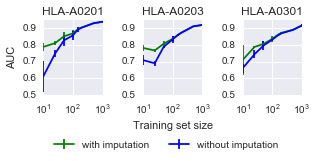

In [42]:
pyplot.figure(figsize=(4.5,2))

for (i, (allele, data)) in enumerate(impute_comparison.groupby("allele")):
    pyplot.subplot(1, 3, i + 1, sharey=pyplot.gca())
    grouped = data.groupby(["train_size", "impute"]).test_auc.mean().to_frame().reset_index()
    grouped["std_error"] = data.groupby(["train_size", "impute"]).test_auc.std().to_frame().reset_index().test_auc
    for impute in [True, False]:
        sub = grouped[grouped.impute == impute]
        pyplot.errorbar(
                       x=sub.train_size.values,
                       y=sub.test_auc.values,
                       yerr=sub.std_error.values,
                       label=("with" if impute else "without") + " imputation",
                       color='green' if impute else 'blue')
    
    #pyplot.xlim(xmin=0, xmax=1000)
    pyplot.title(allele)
    pyplot.xscale("log")
    if i == 0:
        pyplot.ylabel("AUC")
    if i == 1:
        pyplot.xlabel("Training set size")
    pyplot.savefig("../figures/impute_comparison.pdf")

pyplot.legend(loc='lower right', ncol=2, bbox_to_anchor=(.75,-.85))

pyplot.tight_layout()


In [34]:
pyplot.legend?